In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable

In [2]:
path = './dataset/'
all_ = glob.glob(os.path.join(path, "*.csv"))
merged = pd.concat([pd.read_csv(f) for f in all_])
merged.to_csv('./dataset/merged.csv', index=False)

In [3]:
value = pd.read_csv('./dataset/merged.csv')
value = torch.Tensor(value.values)

In [4]:
value.shape

torch.Size([40178, 6])

In [5]:
X = value[:,0]
Y = value[:,1]
Z = value[:,2]
Pitch = value[:,3]
Roll = value[:,4]
Yaw = value[:,5]

In [6]:
all_set = value
all_set.shape

torch.Size([40178, 6])

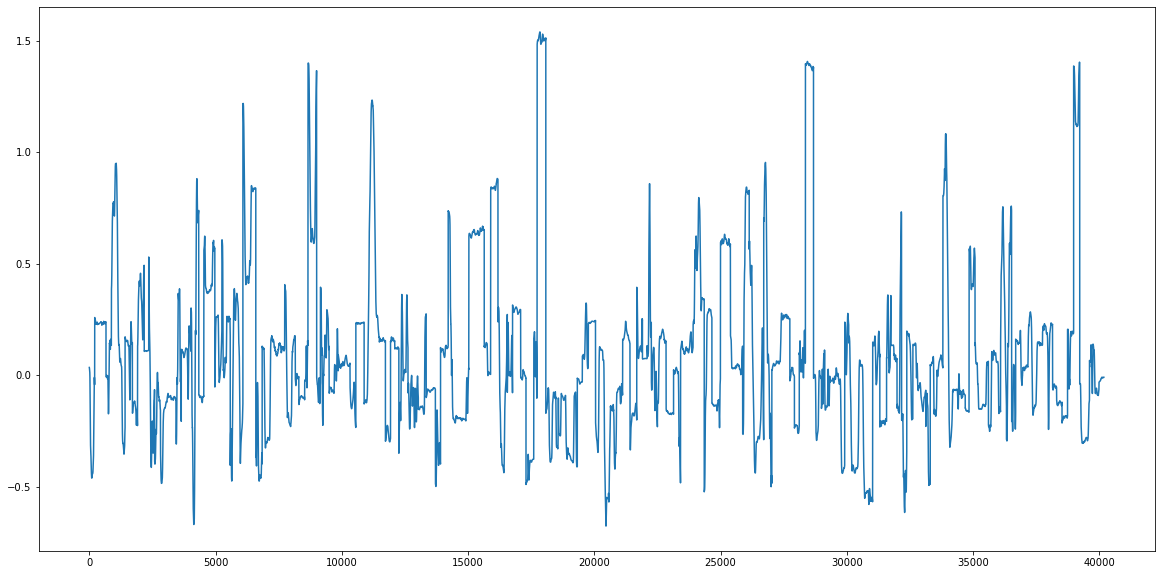

In [15]:
plt.figure(figsize=(20,10))
plt.plot(X)

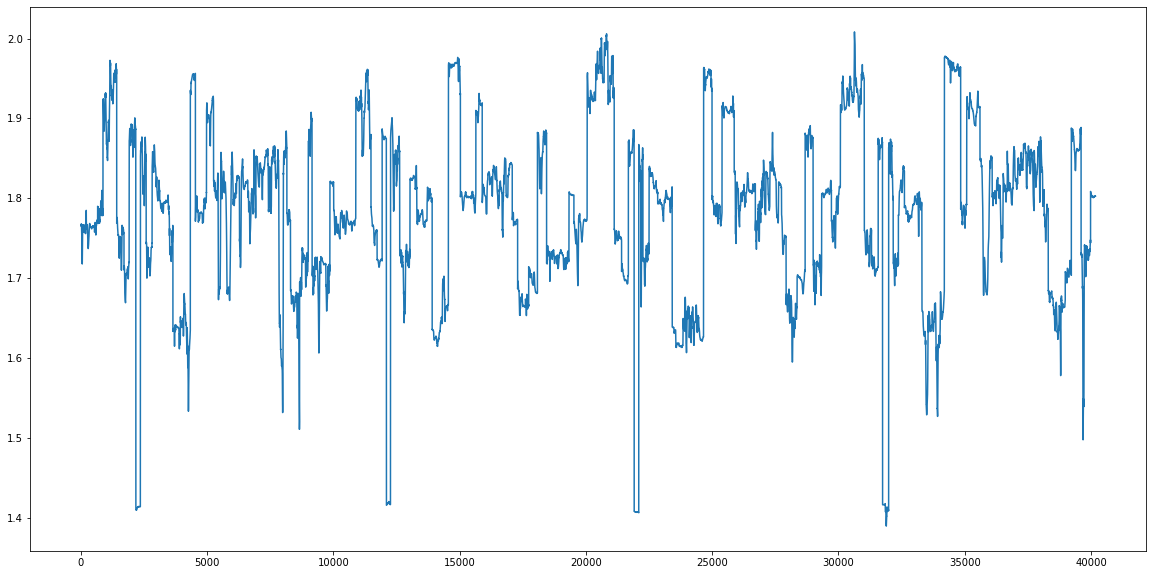

In [14]:
plt.figure(figsize=(20,10))
plt.plot(Y)

In [9]:
from mpl_toolkits import mplot3d

/home/arty/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


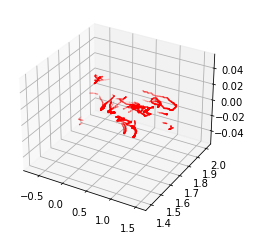

In [13]:
ax = plt.axes(projection='3d')
plt.scatter(X, Y, Z, c='r', marker='o')

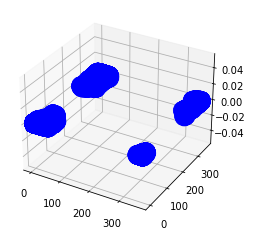

In [54]:
ax = plt.axes(projection='3d')
plt.scatter(Pitch, Roll, Yaw, c='b', marker='o')

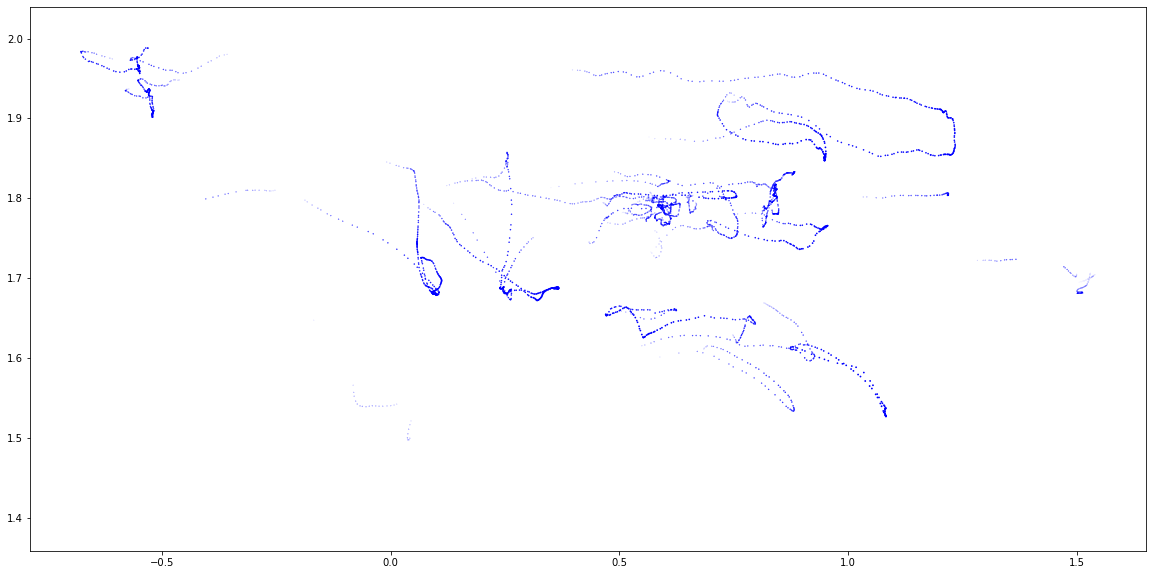

In [17]:
plt.figure(figsize=(20,10))
plt.scatter(X, Y, Z, c='b', marker='o')

### LSTM

In [26]:
value.shape

torch.Size([40178, 6])

In [27]:
training_set = all_set[:,:3]

In [28]:
training_set.shape

torch.Size([40178, 3])

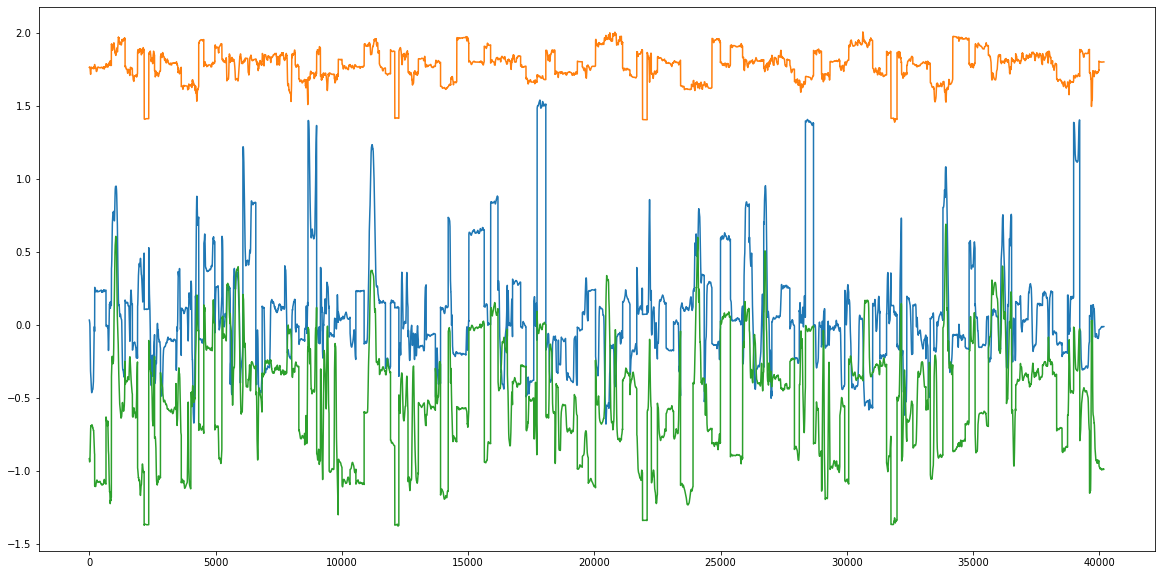

In [23]:
plt.figure(figsize=(20,10))
plt.plot(training_set, label = 'Test')
plt.show()

In [ ]:
trai

In [51]:
training_set

tensor([[ 0.0346,  1.7656, -0.9146],
        [ 0.0341,  1.7666, -0.9166],
        [ 0.0333,  1.7668, -0.9189],
        ...,
        [-0.0088,  1.8029, -0.9871],
        [-0.0089,  1.8028, -0.9868],
        [-0.0090,  1.8028, -0.9866]])

In [29]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))


In [30]:
data = torch.Tensor(training_data)

In [31]:
data.shape

torch.Size([40178, 3])

In [32]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [33]:
trainX.shape, trainY.shape

(torch.Size([26915, 4, 3]), torch.Size([26915, 3]))

In [34]:
testX.shape, testY.shape

(torch.Size([13258, 4, 3]), torch.Size([13258, 3]))

In [35]:
num_epochs = 2000
learning_rate = 0.1

input_size = 3
hidden_size = 2
num_layers = 1

num_classes = 3

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 1.18309
Epoch: 100, loss: 0.02107
Epoch: 200, loss: 0.00945
Epoch: 300, loss: 0.00758
Epoch: 400, loss: 0.00659
Epoch: 500, loss: 0.00572
Epoch: 600, loss: 0.00556
Epoch: 700, loss: 0.00554
Epoch: 800, loss: 0.00553
Epoch: 900, loss: 0.00552
Epoch: 1000, loss: 0.00551
Epoch: 1100, loss: 0.00550
Epoch: 1200, loss: 0.00551
Epoch: 1300, loss: 0.00549
Epoch: 1400, loss: 0.00549
Epoch: 1500, loss: 0.00569
Epoch: 1600, loss: 0.00549
Epoch: 1700, loss: 0.00549
Epoch: 1800, loss: 0.00548
Epoch: 1900, loss: 0.00567


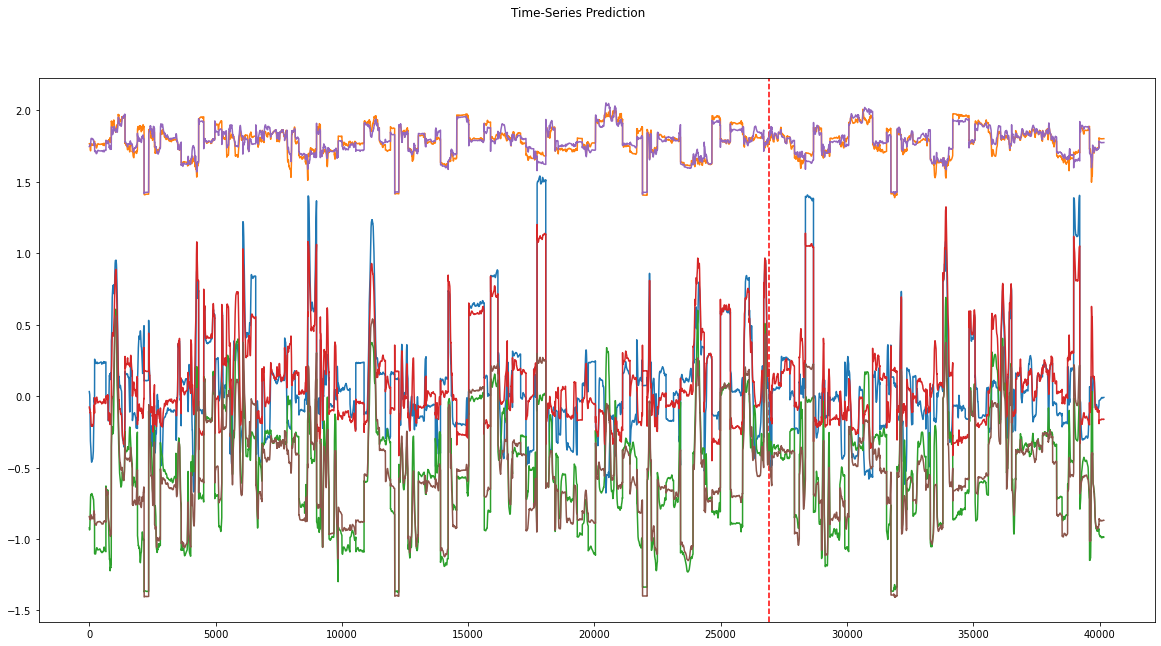

In [37]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)
plt.figure(figsize=(20, 10))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

### Testing for X

In [38]:
x_coord = all_set[:,:1]

In [39]:
x_coord.shape

torch.Size([40178, 1])

In [40]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(x_coord)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size_x = int(len(y) * 0.67)
test_size_x = len(y) - train_size_x

dataX_a = Variable(torch.Tensor(np.array(x)))
dataY_a = Variable(torch.Tensor(np.array(y)))

trainX_coord = Variable(torch.Tensor(np.array(x[0:train_size_x])))
trainY_coord = Variable(torch.Tensor(np.array(y[0:train_size_x])))

testX_coord = Variable(torch.Tensor(np.array(x[train_size_x:len(x)])))
testY_coord = Variable(torch.Tensor(np.array(y[train_size_x:len(y)])))

In [41]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [42]:
num_epochs = 800
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX_coord)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY_coord)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 1.14830
Epoch: 100, loss: 0.01577
Epoch: 200, loss: 0.00110
Epoch: 300, loss: 0.00076
Epoch: 400, loss: 0.00066
Epoch: 500, loss: 0.00061
Epoch: 600, loss: 0.00057
Epoch: 700, loss: 0.00054


In [61]:
lstm

LSTM(
  (lstm): LSTM(3, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=3, bias=True)
)

In [43]:
dataY_plot.shape, data_predict.shape

((40173, 3), (40173, 3))

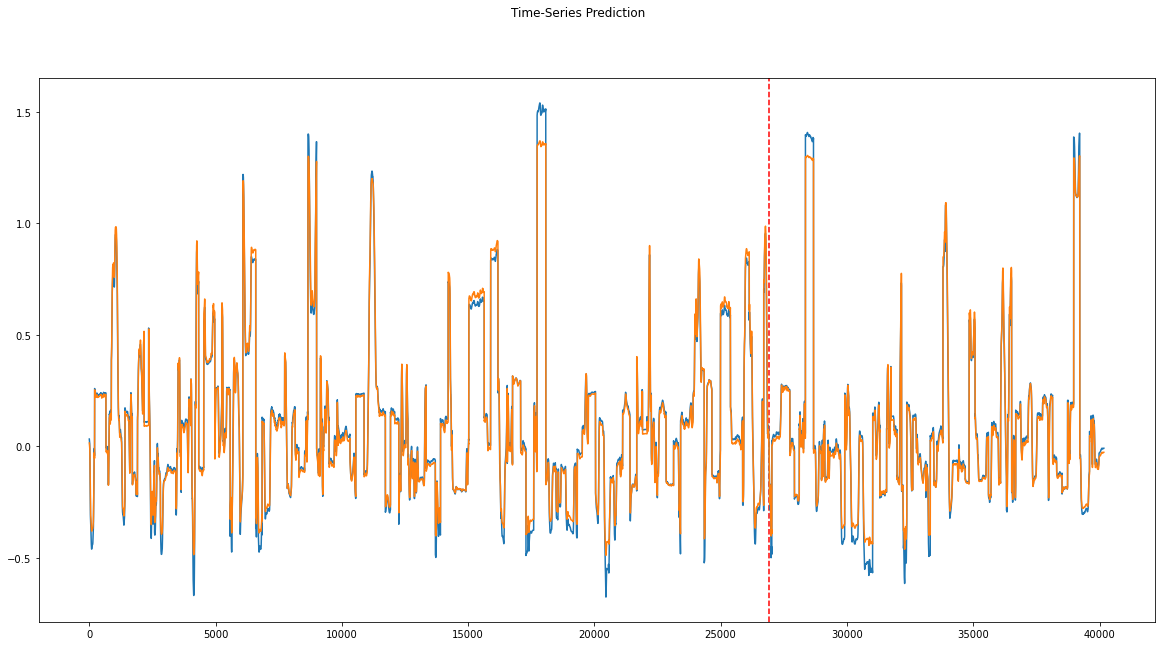

In [44]:
lstm.eval()
train_predict = lstm(dataX_a)
plt.figure(figsize=(20, 10))
data_predict = train_predict.data.numpy()
dataY_plot = dataY_a.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size_x, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

### Training for 6 coordinates

In [45]:
full_coord = value

In [46]:
full_coord = full_coord[:,3:]
full_coord

tensor([[ 13.7244, 356.0449, 346.6967],
        [ 13.6143, 356.4417, 351.0183],
        [ 13.6143, 356.6888, 354.1861],
        ...,
        [  7.1302,   2.3593, 354.7187],
        [  7.1694,   2.3044, 354.7141],
        [  7.1909,   2.2867, 354.6985]])

In [47]:
def seq(data, seq_len):
    x = []
    y = []

    for i in range(len(data)-seq_len-1):
        _x = data[i:(i+seq_len)]
        _y = data[i+seq_len]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
df = sc.fit_transform(full_coord)

seq_len = 2
x, y = seq(df, seq_len)

f_train = int(len(y) * 0.67)
f_test = len(y) - f_train

f_data_x = Variable(torch.Tensor(np.array(x)))
f_data_y = Variable(torch.Tensor(np.array(y)))

f_x = Variable(torch.Tensor(np.array(x[0:f_train])))
f_y = Variable(torch.Tensor(np.array(y[0:f_train])))

f_testx = Variable(torch.Tensor(np.array(x[f_test:len(x)])))
f_testy = Variable(torch.Tensor(np.array(y[f_test:len(y)])))

In [48]:
num_epochs = 200
learning_rate = 0.01

input_size = 3
hidden_size = 2
num_layers = 1
num_classes = 3

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(f_x)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, f_y)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 10 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.51694
Epoch: 10, loss: 0.30563
Epoch: 20, loss: 0.18791
Epoch: 30, loss: 0.12276
Epoch: 40, loss: 0.07865
Epoch: 50, loss: 0.05700
Epoch: 60, loss: 0.04500
Epoch: 70, loss: 0.03513
Epoch: 80, loss: 0.03044
Epoch: 90, loss: 0.02822
Epoch: 100, loss: 0.02640
Epoch: 110, loss: 0.02519
Epoch: 120, loss: 0.02437
Epoch: 130, loss: 0.02373
Epoch: 140, loss: 0.02321
Epoch: 150, loss: 0.02277
Epoch: 160, loss: 0.02239
Epoch: 170, loss: 0.02206
Epoch: 180, loss: 0.02177
Epoch: 190, loss: 0.02152


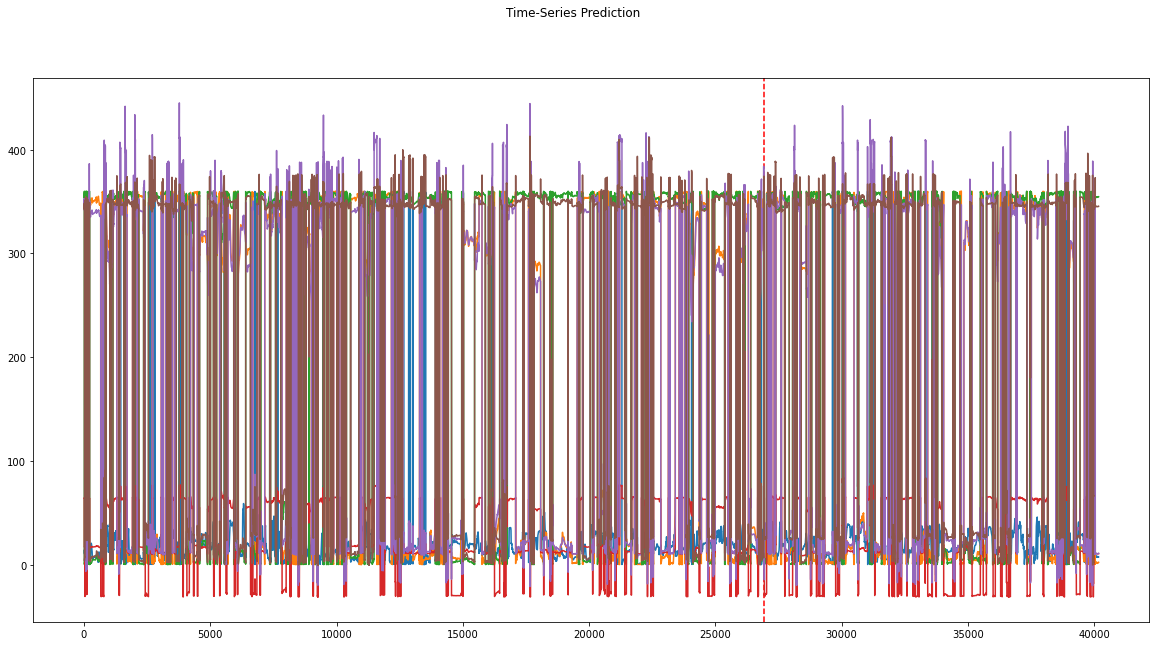

In [50]:
lstm.eval()
train_predict = lstm(f_data_x)

data_predict = train_predict.data.numpy()
dataY_plot = f_data_y.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)
plt.figure(figsize=(20,10))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()